# This notebook will contain the model training process, evaluation, and hyperparameter tuning:

- Model selection using H2O AutoML

- Splitting data into train/test sets

- Model training, evaluation, and cross-validation

- Hyperparameter tuning

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score, recall_score, precision_score
from sklearn.preprocessing import label_binarize
import h2o
from h2o.automl import H2OAutoML
from collections import defaultdict
from imblearn.over_sampling import SMOTENC

### Input 02-notebook file

In [2]:
path = '../data/processed/heart_2022_processed_02.csv'

In [3]:
# read data
df = pd.read_csv(path ,sep=',',encoding='utf-8')
df.sample(5)

,State,Sex,GeneralHealth,PhysicalHealthDays,MentalHealthDays,LastCheckupTime,PhysicalActivities,SleepHours,RemovedTeeth,HadHeartAttack,...,HeightInMeters^2_poly,HeightInMeters_PhysicalHealthDays_poly,HeightInMeters_MentalHealthDays_poly,HeightInMeters_SleepHours_poly,PhysicalHealthDays^2_poly,PhysicalHealthDays_MentalHealthDays_poly,PhysicalHealthDays_SleepHours_poly,MentalHealthDays^2_poly,MentalHealthDays_SleepHours_poly,SleepHours^2_poly
156718,MD,0,3,-0.489368,-0.515761,1,1,-0.018124,0,0,...,0.713712,-0.4883,-0.514716,0.193464,-0.369584,-0.264944,-0.46604,-0.377532,-0.496965,-0.109551
169869,MA,1,2,-0.489368,-0.515761,3,1,-0.018124,1,0,...,0.713712,-0.4883,-0.514716,0.193464,-0.369584,-0.264944,-0.46604,-0.377532,-0.496965,-0.109551
225308,NH,0,4,-0.489368,-0.515761,3,1,0.663840,1,0,...,-0.961225,-0.4883,-0.514716,0.324736,-0.369584,-0.264944,-0.46604,-0.377532,-0.496965,0.541774
250131,NY,1,3,-0.489368,-0.515761,3,1,-0.700087,0,0,...,1.721317,-0.4883,-0.514716,-0.262124,-0.369584,-0.264944,-0.46604,-0.377532,-0.496965,-0.674034
217686,NE,0,2,-0.489368,-0.515761,3,0,0.663840,0,0,...,-0.694458,-0.4883,-0.514716,0.417398,-0.369584,-0.264944,-0.46604,-0.377532,-0.496965,0.541774


In [4]:
output_path = '../data/cleaned/dtype.csv'
df.dtypes.to_csv(output_path)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416184 entries, 0 to 416183
Data columns (total 78 columns):
 #   Column                                            Non-Null Count   Dtype  
---  ------                                            --------------   -----  
 0   State                                             416184 non-null  object 
 1   Sex                                               416184 non-null  int64  
 2   GeneralHealth                                     416184 non-null  int64  
 3   PhysicalHealthDays                                416184 non-null  float64
 4   MentalHealthDays                                  416184 non-null  float64
 5   LastCheckupTime                                   416184 non-null  int64  
 6   PhysicalActivities                                416184 non-null  int64  
 7   SleepHours                                        416184 non-null  float64
 8   RemovedTeeth                                      416184 non-null  int64  
 9   HadH

### H2O AutoML to Select and Train the Best Mode

#### Splitting data into train/test sets


In [6]:
# Start H2O cluster
h2o.init()
# Convert data into H2O frame (required by H2O)
h2o_df = h2o.H2OFrame(df)
h2o_df['HadHeartAttack'] = h2o_df['HadHeartAttack'].asfactor()

# Specify the target column
target = 'HadHeartAttack'

# Define the feature columns
features = [col for col in df.columns if col != target]

# Split the dataset into training and testing sets
train, test = h2o_df.split_frame(ratios=[.8], seed=42)
h2o.export_file(train, path="../data/processed/train_data_03.csv", force=True)
h2o.export_file(test, path="../data/processed/test_data_03.csv", force=True)

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment Homebrew (build 11.0.27+0); OpenJDK 64-Bit Server VM Homebrew (build 11.0.27+0, mixed mode)
  Starting server from /Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmp7me7ff0r
  JVM stdout: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmp7me7ff0r/h2o_chiushihchan_started_from_python.out
  JVM stderr: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmp7me7ff0r/h2o_chiushihchan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Taipei
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_chiushihchan_p33q5s
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,2 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%
Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


#### Obective function

For each sample:

- If the model predicts negative (0):

    - If actual is 0 (TN) → revenue = 271,139

    - If actual is 1 (FN) → revenue = –401,832

- If the model predicts positive (1): 

    - It’s excluded from the revenue calculation (just skip it)


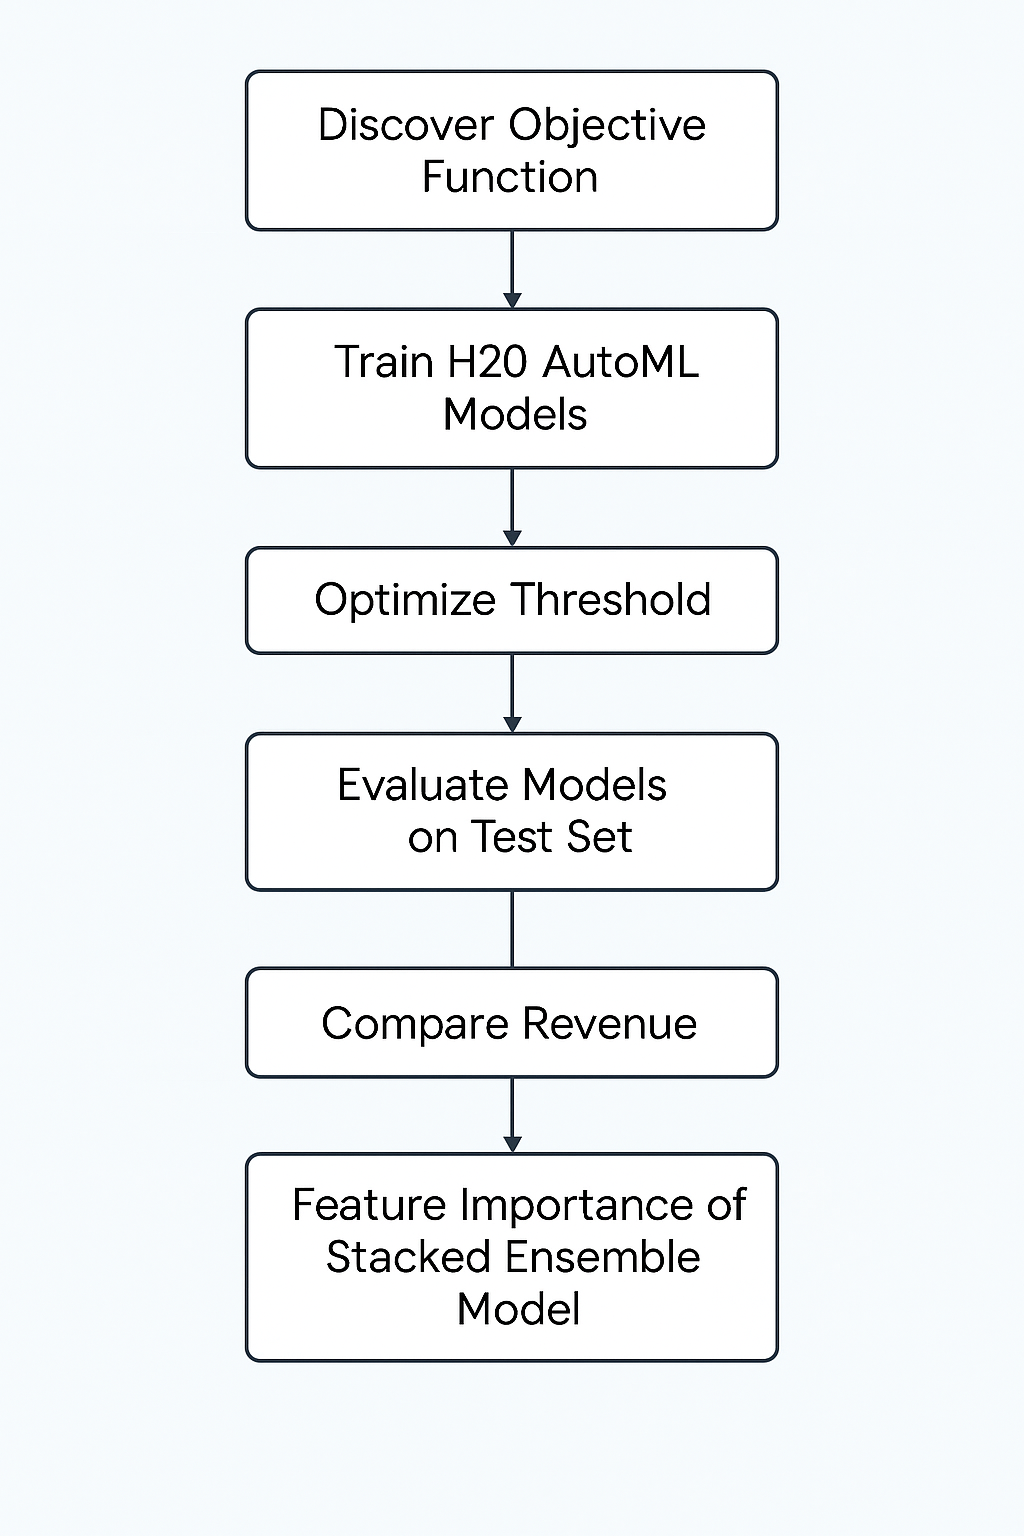

The Revenue Function Implied Weight Ratio
Given:
``` python
TN reward: +271,139
FN cost: -401,832
```

We want the model to learn that FN is ~1.48× worse than TN is good:

``` python
class_0_weight = 271139
class_1_weight = 401832  # higher penalty for misclassifying positives
```
To keep this relative but normalized, you can rescale:

``` python
total = class_0_weight + class_1_weight
sampling_factors = [
    class_1_weight / total,  # class 0
    class_0_weight / total   # class 1
]
```

Which becomes:

``` python
sampling_factors = [0.5976, 0.4024]  # class 0, class 1
```

But to invert this for class weighting (more weight to costly mistakes), we assign higher weight to class 1:

``` python
sampling_factors = [0.4, 0.6]
```
This is more intuitive for H2OAutoML(balance_classes=True).

In [7]:
# Train the AutoML model
aml = H2OAutoML(max_runtime_secs = 600, seed=42, balance_classes=True,
    class_sampling_factors=[0.4, 0.6],  # class 0, class 1
    sort_metric="AUTO"
)
aml.train(x=features, y=target, training_frame=train)

AutoML progress: |
14:28:48.571: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,blending
Number of base models (used / total),5/5
# GBM base models (used / total),1/1
# GLM base models (used / total),1/1
# DeepLearning base models (used / total),1/1
# DRF base models (used / total),2/2
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,None


In [8]:
#  Define custom revenue function
def total_revenue(y_true, y_pred):
    return sum(
        271_139 if (yp == 0 and yt == 0) else
       -401_832 if (yp == 0 and yt == 1) else
        0
        for yt, yp in zip(y_true, y_pred)
    )

In [9]:
def optimize_revenue_threshold(y_true, y_probs, thresholds=np.linspace(0, 1, 100)):
    best_threshold = 0.5
    best_revenue = float('-inf')

    for t in thresholds:
        y_pred = (y_probs >= t).astype(int)
        revenue = total_revenue(y_true, y_pred)
        if revenue > best_revenue:
            best_revenue = revenue
            best_threshold = t

    return best_threshold, best_revenue

In [10]:
leaderboard = aml.leaderboard.as_data_frame()
model_ids = leaderboard['model_id'].tolist()[:10]  # top-10 models

validation_revenue_records = []

for model_id in model_ids:
    model = h2o.get_model(model_id)
    preds = model.predict(train)
    y_probs = preds['p1'].as_data_frame().values.flatten()
    y_true = train[target].as_data_frame().values.flatten()

    threshold, revenue = optimize_revenue_threshold(y_true, y_probs)

    validation_revenue_records.append({
        "model_id": model_id,
        "threshold": threshold,
        "validation_revenue": revenue
    })

stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [11]:
test_results = []

for record in validation_revenue_records:
    model = h2o.get_model(record["model_id"])
    threshold = record["threshold"]
    
    preds = model.predict(test)
    y_probs = preds['p1'].as_data_frame().values.flatten()
    y_true = test[target].as_data_frame().values.flatten()
    y_pred = (y_probs >= threshold).astype(int)

    revenue = total_revenue(y_true, y_pred)

    test_results.append({
        "model_id": record["model_id"],
        "threshold": threshold,
        "test_revenue": revenue,
        "validation_revenue": record["validation_revenue"]
    })

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
glm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [12]:
# Baseline: always predict negative
y_true_baseline = test[target].as_data_frame().values.flatten()
baseline_revenue = sum(
    271_139 if y == 0 else -401_832 for y in y_true_baseline
)

print(f"📉 Baseline (no model) revenue on test set: {baseline_revenue:,}")

📉 Baseline (no model) revenue on test set: 19,426,870,912


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [13]:
results_df = pd.DataFrame(test_results)
results_df = results_df.sort_values(by="test_revenue", ascending=False)

results_df["gain_vs_baseline"] = results_df["test_revenue"] - baseline_revenue

print("Top revenue models on test set:")
results_df

Top revenue models on test set:


,model_id,threshold,test_revenue,validation_revenue,gain_vs_baseline
1,StackedEnsemble_AllModels_3_AutoML_1_20250529_...,0.414141,19664152799,79375061345,237281887
2,StackedEnsemble_AllModels_4_AutoML_1_20250529_...,0.414141,19662836116,79359912669,235965204
0,StackedEnsemble_BestOfFamily_4_AutoML_1_202505...,0.404040,19656543346,79178138310,229672434
6,StackedEnsemble_BestOfFamily_2_AutoML_1_202505...,0.393939,19654013373,79287701918,227142461
7,StackedEnsemble_BestOfFamily_1_AutoML_1_202505...,0.404040,19653192148,78971031002,226321236
9,GBM_grid_1_AutoML_1_20250529_142848_model_47,0.383838,19652318268,78935312857,225447356
4,StackedEnsemble_AllModels_1_AutoML_1_20250529_...,0.393939,19651461935,79367463618,224591023
3,StackedEnsemble_AllModels_2_AutoML_1_20250529_...,0.414141,19650215468,79381422372,223344556
5,StackedEnsemble_BestOfFamily_3_AutoML_1_202505...,0.393939,19649374751,79272297719,222503839
8,GLM_1_AutoML_1_20250529_142848,0.383838,19637750882,78754913699,210879970


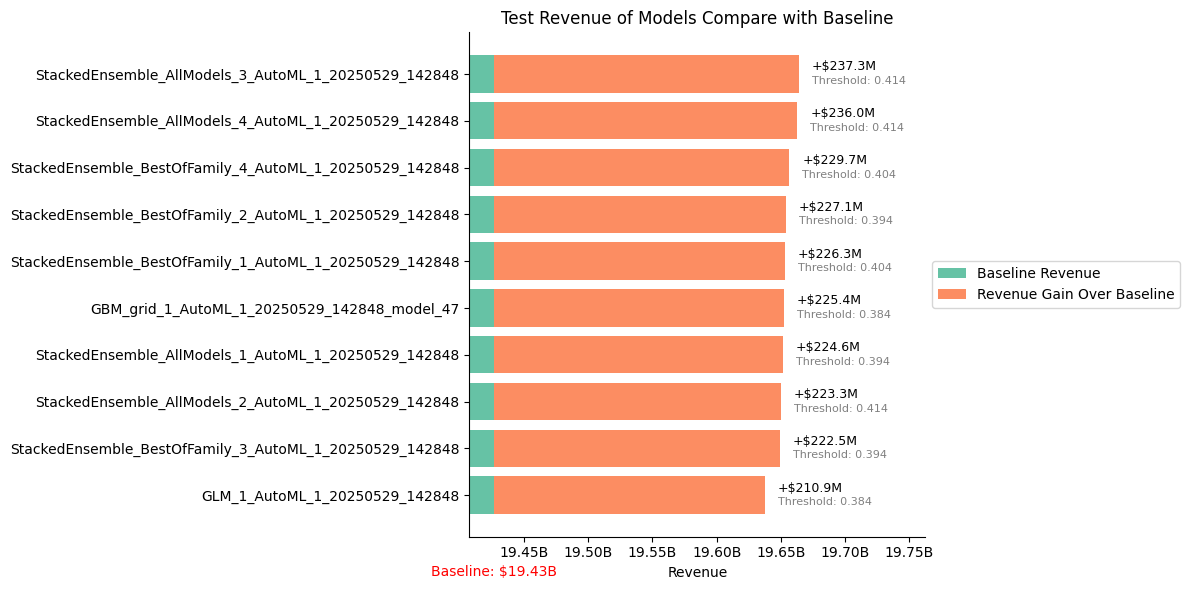

In [14]:
sorted_filtered_df = results_df.sort_values(by="test_revenue", ascending=True).reset_index(drop=True)

palette = sns.color_palette("Set2", n_colors=2)
green_color = palette[0]
orange_color = palette[1]

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

for i, row in sorted_filtered_df.iterrows():
    model = row["model_id"]
    revenue = row["test_revenue"]
    gain = row["gain_vs_baseline"]
    threshold = row["threshold"]
    y_pos = i

    ax.barh(y_pos, baseline_revenue, color=green_color, label="Baseline Revenue" if i == 0 else "")
    ax.barh(y_pos, revenue - baseline_revenue, left=baseline_revenue, color=orange_color, label="Revenue Gain Over Baseline" if i == 0 else "")
    
    # Annotate gain
    ax.text(revenue + 1e7, y_pos + 0.15, f"+${gain/1e6:.1f}M", va='center', fontsize=9)
    
    # Annotate threshold
    ax.text(revenue + 1e7, y_pos - 0.15, f"Threshold: {threshold:.3f}", va='center', fontsize=8, color='gray')

# Axis formatting
ax.set_yticks(range(len(sorted_filtered_df)))
ax.set_yticklabels(sorted_filtered_df["model_id"])
ax.set_xlabel("Revenue")
ax.set_title("Test Revenue of Models Compare with Baseline")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e9:.2f}B'))
ax.set_xlim(baseline_revenue * 0.999, sorted_filtered_df["test_revenue"].max() * 1.005)

# Move baseline annotation slightly downward to avoid overlap
ax.text(baseline_revenue, -1.5, f"Baseline: ${baseline_revenue/1e9:.2f}B", ha='center', va='top', fontsize=10, color='red')

# Clean up the plot
sns.despine(top=True, right=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.tight_layout()
plt.show()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


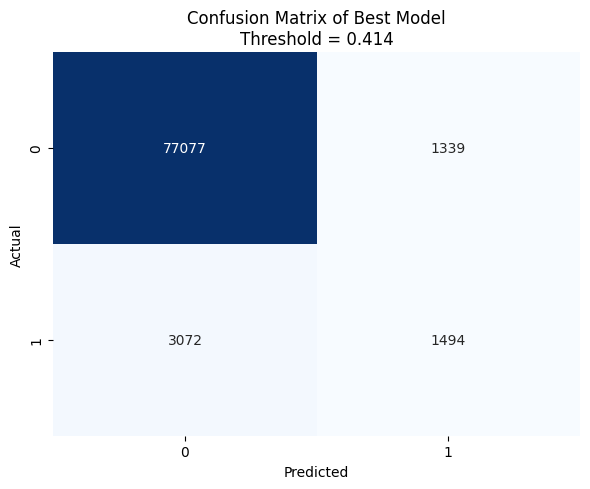

In [15]:
# Assume best model is the top one in results_df
best_model_id = results_df.sort_values(by="test_revenue", ascending=False).iloc[0]["model_id"]
best_threshold = results_df.sort_values(by="test_revenue", ascending=False).iloc[0]["threshold"]

# Retrieve the best model from H2O
best_model = h2o.get_model(best_model_id)

# Get predictions
preds = best_model.predict(test)
y_probs = preds['p1'].as_data_frame().values.flatten()
y_pred = (y_probs >= best_threshold).astype(int)
y_true = test[target].as_data_frame().values.flatten()

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix of Best Model\nThreshold = {best_threshold:.3f}")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

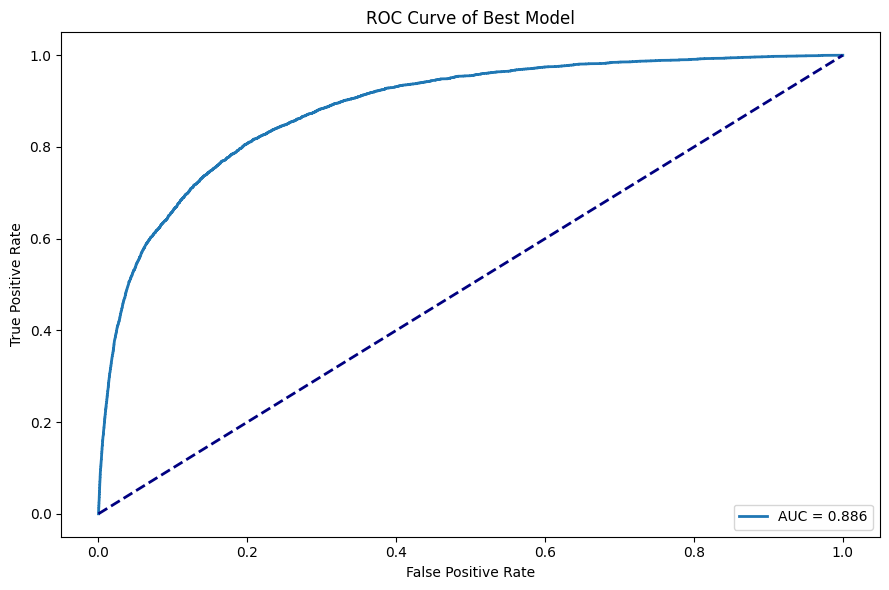

In [16]:
# AUC curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(9, 6))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f"ROC Curve of Best Model")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [17]:
best_model = h2o.get_model(best_model_id)
preds = best_model.predict(test)
y_probs = preds['p1'].as_data_frame().values.flatten()
y_pred = (y_probs >= best_threshold).astype(int)
y_true = test[target].as_data_frame().values.flatten()

# Compute metrics
metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred),
    "AUC": roc_auc_score(y_true, y_probs)
}

# Format as DataFrame
metrics_df = pd.DataFrame(metrics, index=["Score"]).T
metrics_df.reset_index(inplace=True)
metrics_df.columns = ["Metric", "Value"]

print("Metrics of Best Model")
metrics_df

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
Metrics of Best Model


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,Metric,Value
0,Accuracy,0.946844
1,Precision,0.527356
2,Recall,0.327201
3,F1 Score,0.403838
4,AUC,0.885840


In [18]:
meta_model = best_model.metalearner()
meta_varimp = meta_model.varimp(use_pandas=True)
meta_weights = meta_varimp.set_index("variable")["percentage"].to_dict()

# Loop through base models and accumulate weighted importance
global_importance = defaultdict(float)

for base_model_id, weight in meta_weights.items():
    try:
        model = h2o.get_model(base_model_id)
        varimp_df = model.varimp(use_pandas=True)

        for _, row in varimp_df.iterrows():
            feature = row["variable"]
            importance = row["scaled_importance"]
            global_importance[feature] += weight * importance
    except Exception as e:
        print(f"Skipping {base_model_id}: {e}")

# Normalize and output as a DataFrame
global_importance_df = pd.DataFrame(list(global_importance.items()), columns=["feature", "weighted_importance"])
total = global_importance_df["weighted_importance"].sum()
global_importance_df["global_percentage"] = global_importance_df["weighted_importance"] / total
global_importance_df = global_importance_df.sort_values(by="global_percentage", ascending=False).reset_index(drop=True)

global_importance_df.head(10)

,feature,weighted_importance,global_percentage
0,HadAngina,0.947738,0.095411
1,State,0.271982,0.027381
2,AgeCategory,0.268612,0.027042
3,GeneralHealth,0.216551,0.021801
4,ChestScan,0.187952,0.018922
5,HadStroke,0.153643,0.015468
6,Sex,0.145370,0.014635
7,HighRiskLastYear,0.138041,0.013897
8,RemovedTeeth,0.116924,0.011771
9,HadSkinCancer,0.116432,0.011721


In [19]:
meta_varimp

,variable,relative_importance,scaled_importance,percentage
0,DeepLearning_grid_1_AutoML_1_20250529_142848_m...,0.137888,1.000000,0.089276
1,DRF_1_AutoML_1_20250529_142848,0.113892,0.825973,0.073740
2,GLM_1_AutoML_1_20250529_142848,0.112268,0.814198,0.072688
3,GBM_grid_1_AutoML_1_20250529_142848_model_6,0.105483,0.764986,0.068295
4,GBM_grid_1_AutoML_1_20250529_142848_model_22,0.102819,0.745667,0.066570
...,...,...,...,...
64,GBM_grid_1_AutoML_1_20250529_142848_model_3,0.000000,0.000000,0.000000
65,GBM_grid_1_AutoML_1_20250529_142848_model_24,0.000000,0.000000,0.000000
66,GBM_grid_1_AutoML_1_20250529_142848_model_56,0.000000,0.000000,0.000000
67,DeepLearning_grid_1_AutoML_1_20250529_142848_m...,0.000000,0.000000,0.000000


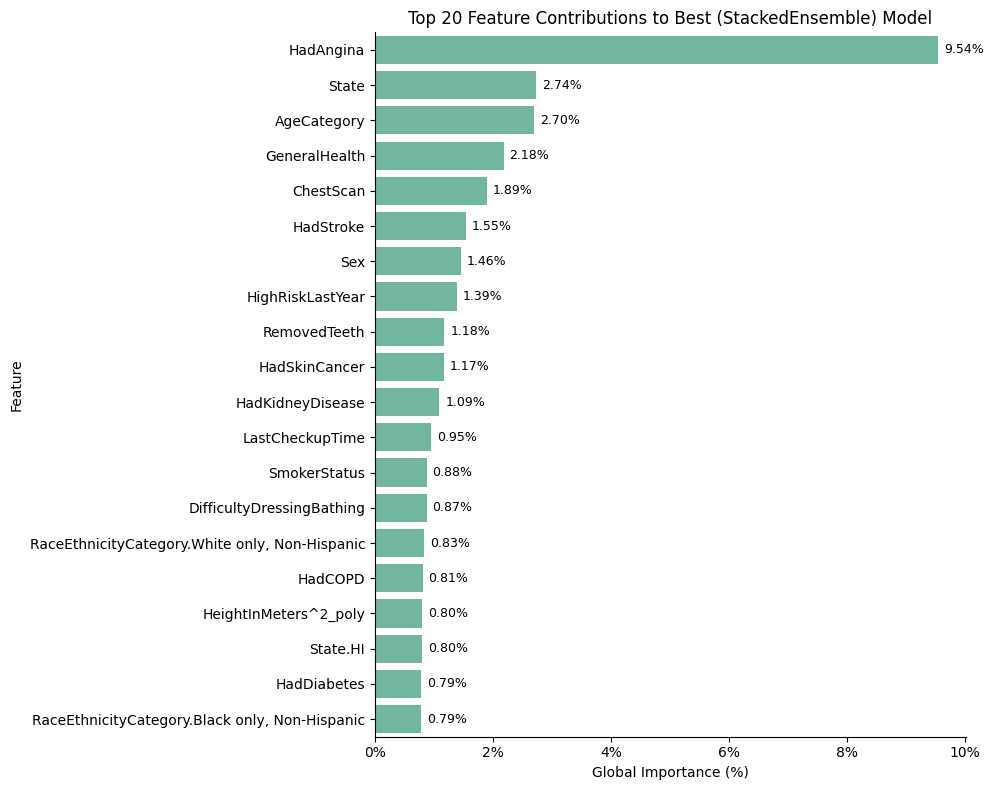

In [20]:
# Plot
top_k = 20
top_features_df = global_importance_df.sort_values(by="global_percentage", ascending=False).head(top_k)

plt.figure(figsize=(10, 8))
ax = sns.barplot(data=top_features_df, x="global_percentage", y="feature", color = green_color)

# Add value annotations
for i, (value, feature) in enumerate(zip(top_features_df["global_percentage"], top_features_df["feature"])):
    ax.text(value + 0.001, i, f"{value*100:.2f}%", va='center', fontsize=9)

plt.xlabel("Global Importance (%)")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.ylabel("Feature")
plt.title("Top 20 Feature Contributions to Best (StackedEnsemble) Model")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

In [21]:
# Save model
model_path = h2o.save_model(model=best_model, path="../models", force=True)

print(f"Model saved to: {model_path}")

Model saved to: /Users/chiushihchan/Local/ML-Project-with-Cathay-Life/models/StackedEnsemble_AllModels_3_AutoML_1_20250529_142848


### Combining SMOTENC Technique

In [22]:
# Apply SMOTENC
train_pd = train.as_data_frame()

X_train = train_pd.drop(columns=[target])
y_train = train_pd[target]

categorical_cols = ['State', 'RaceEthnicityCategory']
categorical_indices = [X_train.columns.get_loc(col) for col in categorical_cols]


smote_nc = SMOTENC(categorical_features=categorical_indices, random_state=42)
X_train_sm, y_train_sm = smote_nc.fit_resample(X_train, y_train)

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [23]:
train_smote_df = pd.concat([X_train_sm, y_train_sm], axis=1)
train_smote_df.to_csv("../data/processed/heart_2022_smote_03.csv", index=False)
test = h2o.import_file("../data/processed/test_data_03.csv",)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [25]:
h2o.shutdown(prompt=False)
h2o.init(max_mem_size="8G")

train_smote = h2o.import_file("../data/processed/heart_2022_smote_03.csv")
train_smote[target] = train_smote[target].asfactor()

Checking whether there is an H2O instance running at http://localhost:54321.

/var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/ipykernel_40286/2382348473.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown(prompt=False)


.... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.27" 2025-04-15; OpenJDK Runtime Environment Homebrew (build 11.0.27+0); OpenJDK 64-Bit Server VM Homebrew (build 11.0.27+0, mixed mode)
  Starting server from /Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpe3umgdx2
  JVM stdout: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpe3umgdx2/h2o_chiushihchan_started_from_python.out
  JVM stderr: /var/folders/m8/ykg0q6ys6kjgjpsxfkdzy6rw0000gn/T/tmpe3umgdx2/h2o_chiushihchan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,01 secs
H2O_cluster_timezone:,Asia/Taipei
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,2 months and 1 day
H2O_cluster_name:,H2O_from_python_chiushihchan_46iywy
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [26]:
features = [col for col in train_smote.columns if col != target]

In [27]:
aml = H2OAutoML(max_runtime_secs = 600, seed=42, balance_classes=True,
    class_sampling_factors=[0.4, 0.6],  # class 0, class 1
    sort_metric="AUTO")
aml.train(x=features, y=target, training_frame=train_smote, leaderboard_frame=test)

AutoML progress: |
14:46:14.967: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%


key,value
Stacking strategy,blending
Number of base models (used / total),4/14
# GBM base models (used / total),4/8
# DRF base models (used / total),0/2
# GLM base models (used / total),0/1
# DeepLearning base models (used / total),0/3
Metalearner algorithm,GLM
Metalearner fold assignment scheme,AUTO
Metalearner nfolds,0
Metalearner fold_column,None


In [28]:
leaderboard = aml.leaderboard.as_data_frame()
model_ids = leaderboard['model_id'].tolist()[:10]
leaderboard

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
0,StackedEnsemble_AllModels_3_AutoML_1_20250529_...,0.992671,0.102413,0.993850,0.035980,0.168366,0.028347
1,StackedEnsemble_BestOfFamily_4_AutoML_1_202505...,0.991746,0.112196,0.992782,0.039437,0.176179,0.031039
2,GBM_grid_1_AutoML_1_20250529_144613_model_3,0.991744,0.113983,0.992781,0.039374,0.178894,0.032003
3,StackedEnsemble_AllModels_1_AutoML_1_20250529_...,0.991617,0.107084,0.993142,0.037883,0.172428,0.029731
4,StackedEnsemble_AllModels_2_AutoML_1_20250529_...,0.991617,0.107084,0.993142,0.037883,0.172428,0.029731
5,StackedEnsemble_BestOfFamily_3_AutoML_1_202505...,0.991244,0.111200,0.992732,0.039342,0.175883,0.030935
6,StackedEnsemble_BestOfFamily_1_AutoML_1_202505...,0.991244,0.111200,0.992732,0.039342,0.175883,0.030935
7,StackedEnsemble_BestOfFamily_2_AutoML_1_202505...,0.991244,0.111200,0.992732,0.039342,0.175883,0.030935
8,GBM_1_AutoML_1_20250529_144613,0.991241,0.111170,0.992732,0.039342,0.176054,0.030995
9,GBM_4_AutoML_1_20250529_144613,0.990481,0.113798,0.992309,0.039881,0.177026,0.031338


In [29]:
validation_revenue_records = []

for model_id in model_ids[:10]:
    model = h2o.get_model(model_id)
    preds = model.predict(train_smote)
    y_probs = preds['p1'].as_data_frame().values.flatten()
    y_true = train_smote_df[target].values.flatten()

    threshold, revenue = optimize_revenue_threshold(y_true, y_probs)

    validation_revenue_records.append({
        "model_id": model_id,
        "threshold": threshold,
        "validation_revenue": revenue,
        "source": "SMOTENC"
    })
    
test = h2o.import_file(
    path="../data/processed/test_data_03.csv", 
    destination_frame="test_data_03.hex"
)
test[target] = test[target].asfactor()

test_results = []
for record in validation_revenue_records:
    model = h2o.get_model(record["model_id"])
    preds = model.predict(test)
    y_probs = preds['p1'].as_data_frame().values.flatten()
    y_true = test[target].as_data_frame().values.flatten()
    y_pred = (y_probs >= record["threshold"]).astype(int)

    revenue = total_revenue(y_true, y_pred)

    test_results.append({
        "model_id": record["model_id"],
        "threshold": record["threshold"],
        "test_revenue": revenue,
        "validation_revenue": record["validation_revenue"],
        "source": record["source"]
    })


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%
gbm prediction progress: |

/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [30]:
smote_df = pd.DataFrame(test_results)
smote_df["gain_vs_baseline"] = smote_df["test_revenue"] - baseline_revenue
combined_results = pd.concat([results_df.assign(source="original"), smote_df], ignore_index=True)
sorted_combined = combined_results.sort_values(by="test_revenue", ascending=True).reset_index(drop=True)
sorted_combined

,model_id,threshold,test_revenue,validation_revenue,gain_vs_baseline,source
0,GBM_grid_1_AutoML_1_20250529_144613_model_3,0.585859,19196293674,79720740524,-230577238,SMOTENC
1,StackedEnsemble_BestOfFamily_4_AutoML_1_202505...,0.525253,19198651997,79717063559,-228218915,SMOTENC
2,StackedEnsemble_AllModels_3_AutoML_1_20250529_...,0.444444,19262065388,80528483223,-164805524,SMOTENC
3,GBM_4_AutoML_1_20250529_144613,0.464646,19297884995,79105555238,-128985917,SMOTENC
4,StackedEnsemble_AllModels_2_AutoML_1_20250529_...,0.444444,19310136974,79759008134,-116733938,SMOTENC
5,StackedEnsemble_AllModels_1_AutoML_1_20250529_...,0.444444,19310136974,79759008134,-116733938,SMOTENC
6,StackedEnsemble_BestOfFamily_2_AutoML_1_202505...,0.494949,19333967933,79571898786,-92902979,SMOTENC
7,StackedEnsemble_BestOfFamily_1_AutoML_1_202505...,0.494949,19333967933,79571898786,-92902979,SMOTENC
8,StackedEnsemble_BestOfFamily_3_AutoML_1_202505...,0.494949,19333967933,79571898786,-92902979,SMOTENC
9,GBM_1_AutoML_1_20250529_144613,0.505051,19334098626,79573084776,-92772286,SMOTENC


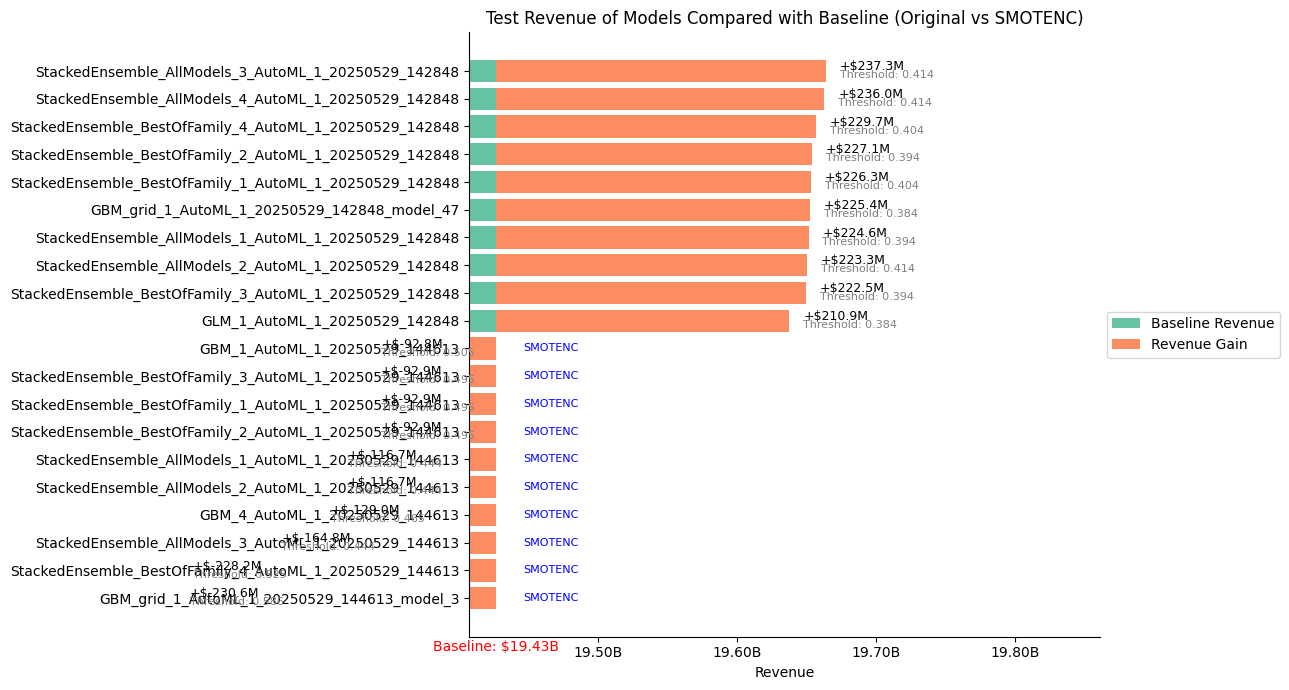

In [31]:
palette = sns.color_palette("Set2", n_colors=2)
green_color = palette[0]
orange_color = palette[1]

fig, ax = plt.subplots(figsize=(13, 7))
for i, row in sorted_combined.iterrows():
    model = row["model_id"]
    revenue = row["test_revenue"]
    gain = row["gain_vs_baseline"]
    threshold = row["threshold"]
    source = row["source"]
    y_pos = i

    ax.barh(y_pos, baseline_revenue, color=green_color, label="Baseline Revenue" if i == 0 else "")
    ax.barh(y_pos, revenue - baseline_revenue, left=baseline_revenue, color=orange_color, label="Revenue Gain" if i == 0 else "")
    ax.text(revenue + 1e7, y_pos + 0.15, f"+${gain/1e6:.1f}M", va='center', fontsize=9)
    ax.text(revenue + 1e7, y_pos - 0.15, f"Threshold: {threshold:.3f}", va='center', fontsize=8, color='gray')

    # Mark SMOTENC models
    if source == "SMOTENC":
        ax.text(baseline_revenue * 1.001, y_pos, "SMOTENC", va='center', fontsize=8, color='blue')

ax.set_yticks(range(len(sorted_combined)))
ax.set_yticklabels(sorted_combined["model_id"])
ax.set_xlabel("Revenue")
ax.set_title("Test Revenue of Models Compared with Baseline (Original vs SMOTENC)")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x/1e9:.2f}B'))
ax.set_xlim(baseline_revenue * 0.999, sorted_combined["test_revenue"].max() * 1.01)
ax.text(baseline_revenue, -1.5, f"Baseline: ${baseline_revenue/1e9:.2f}B", ha='center', va='top', fontsize=10, color='red')
sns.despine(top=True, right=True)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

gbm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"
/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


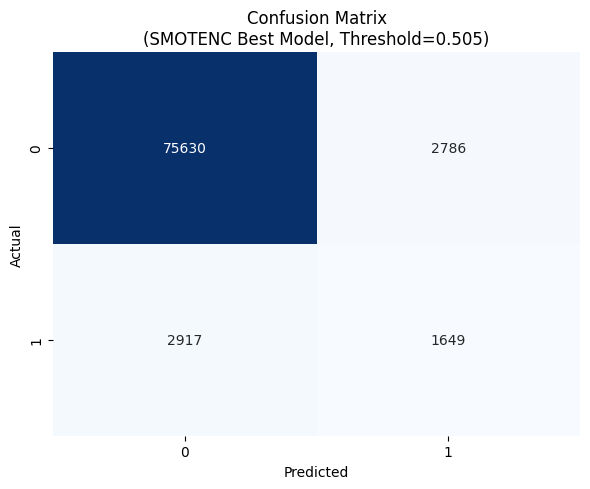

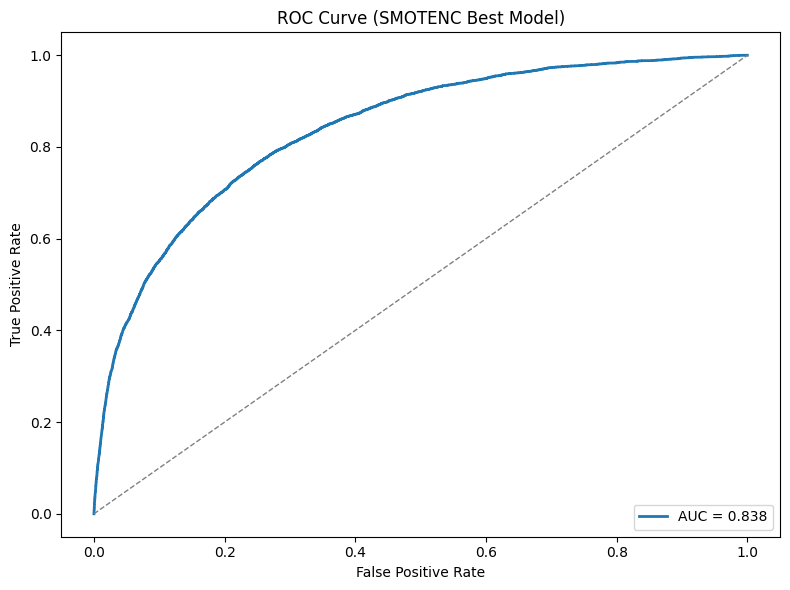

In [32]:
# ========== BEST SMOTENC MODEL EVAL ==========
best_model_row = smote_df.sort_values(by="test_revenue", ascending=False).iloc[0]
best_model_id = best_model_row["model_id"]
best_threshold = best_model_row["threshold"]

best_model = h2o.get_model(best_model_id)
preds = best_model.predict(test)
y_probs = preds['p1'].as_data_frame().values.flatten()
y_pred = (y_probs >= best_threshold).astype(int)
y_true = test[target].as_data_frame().values.flatten()

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.title(f"Confusion Matrix\n(SMOTENC Best Model, Threshold={best_threshold:.3f})")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# AUC Curve
fpr, tpr, _ = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title("ROC Curve (SMOTENC Best Model)")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

In [33]:
# ========== GLOBAL FEATURE IMPORTANCE ==========
meta_model = best_model.metalearner()
meta_varimp = meta_model.varimp(use_pandas=True)
meta_weights = meta_varimp.set_index("variable")["percentage"].to_dict()

global_importance = defaultdict(float)
for base_model_id, weight in meta_weights.items():
    try:
        model = h2o.get_model(base_model_id)
        varimp_df = model.varimp(use_pandas=True)
        for _, row in varimp_df.iterrows():
            global_importance[row["variable"]] += weight * row["scaled_importance"]
    except:
        pass

global_importance_df = pd.DataFrame(list(global_importance.items()), columns=["feature", "weighted_importance"])
total = global_importance_df["weighted_importance"].sum()
global_importance_df["global_percentage"] = global_importance_df["weighted_importance"] / total
global_importance_df = global_importance_df.sort_values(by="global_percentage", ascending=False)

# Plot
top_k = 20
top_features_df = global_importance_df.head(top_k)

plt.figure(figsize=(10, 8))
ax = sns.barplot(data=top_features_df, x="global_percentage", y="feature", color="seagreen")
for i, (value, feature) in enumerate(zip(top_features_df["global_percentage"], top_features_df["feature"])):
    ax.text(value + 0.001, i, f"{value*100:.2f}%", va='center', fontsize=9)
plt.xlabel("Global Importance (%)")
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'{x*100:.0f}%'))
plt.ylabel("Feature")
plt.title("Top 20 Feature Contributions (SMOTENC StackedEnsemble)")
sns.despine(top=True, right=True)
plt.tight_layout()
plt.show()

AttributeError: type object 'ModelBase' has no attribute 'metalearner'

### GANs Models

### Deep Learnings Models

### Compare All Models

### SHAP

In [ ]:
# Get SHAP values for the test set
contributions = best_model.predict_contributions(test)

# Convert to DataFrame
shap_df = contributions.as_data_frame()

# Remove the last column ('BiasTerm')
shap_df = shap_df.drop(columns=["BiasTerm"])

contributions progress: |████████████████████████████████████████████████████████| (done) 100%


/Users/chiushihchan/Local/ML-Project-with-Cathay-Life/.venv/lib/python3.13/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


In [ ]:
import shap

# Convert to NumPy for SHAP
shap_values = shap_df.values
feature_names = shap_df.columns

# Initialize SHAP explainer (Dummy — needed for plotting only)
explainer = shap.Explainer(lambda x: shap_values, feature_names)

# Create dummy "test" data matrix for visualization
X_sample = test[:, feature_names].as_data_frame()

# Plot SHAP summary (like beeswarm)
shap.summary_plot(shap_values, X_sample, feature_names=feature_names)

ModuleNotFoundError: No module named 'shap'

In [ ]:
# Visualize the first prediction
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], X_sample.iloc[0])
